In [268]:
cd SRS/

[WinError 2] El sistema no puede encontrar el archivo especificado: 'SRS/'
d:\Documentos\ic_tps\SRS


In [269]:
import numpy as np
from srs import SRGA
from Evolutivo.evolutivo import GA
from tqdm import tqdm
from utils import fitness

n_bits = 30

# Alfa, Umbral, Phi(5), Psi(5)
var_bits = np.ones(12, dtype=int) * 30
var_lims = np.zeros(13, dtype=int)
var_lims[:-1] = np.arange(0, 12) * var_bits
var_lims[-1] = int(n_bits*12)
var_min  = np.array(
    [0, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]
)
var_max  = np.array(
    [100, 1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
)

interrev = 1 * 24 * 3600
nvent = 5
ancho_ventanas = np.exp( np.log(15) / nvent * np.arange(1, nvent+1))
ancho_ventanas *= (24 * 3600)

In [270]:
def DecoDecimal(v, a=var_min, b=var_max):
    vs = []
    for i in range(len(var_lims)-1):
        vs.append(v[var_lims[i]:var_lims[i+1]])

    xs = []
    xs = np.zeros(a.size)

    for (i,vi) in enumerate(vs):
        k = len(vi)
        d = sum(2**(k-np.array(range(1,k+1)))*vi)
        xs[i] = a[i] + (d*((b[i]-a[i])/((2**k)-1)))

    return xs

In [271]:
cd ..

d:\Documentos\ic_tps


In [272]:
#Cargar las matrices m_t, m_c, m_s y a lens
m_t = np.load('SRS/data/times.npy')
m_c = np.load('SRS/data/correct.npy')
m_s = np.load('SRS/data/seen.npy')
m_d = np.load('SRS/data/lexemes_dificulty.npy')
lens = np.load('SRS/data/len_schedule.npy')
lens = lens.astype(int)

#Cargamos los acums ("ASCO")
m_acum_cs = np.load('SRS/data/acum_c-res1000-sigma30.npy')
m_acum_ss = np.load('SRS/data/acum_s-res1000-sigma30.npy')

# NUMEROS MAGICOS
N = m_t.shape[0]    #Cantidad total de schedules
n = 500              #Cantidad de schedules para cada individuo

# Inicializamos la clase SRGA, que preprocesa los datos si hace falta
SRGA.init_class(lens, m_t, m_c, m_s, m_d, res=1000)

---INICIA init_acums---
Cargando datos cacheados...


In [273]:
# Calculamos particiones
N_parts = 5
prct_train = .80
len_part_train = int(N*prct_train)

parts_train = []
parts_test = []

idx = np.arange(0, N)

for i in range(N_parts):
    np.random.shuffle(idx)

    parts_train.append(list(idx[:len_part_train]))
    parts_test.append(list(idx[len_part_train:]))


In [274]:
print(f"Schedules entrenamiento: {len(parts_train[1])}")
print(f"Schedules testeo: {len(parts_test[1])}")
print(f"Schedules totales: {len(parts_test[1])+len(parts_train[1])}")

Schedules entrenamiento: 4993
Schedules testeo: 1249
Schedules totales: 6242


In [275]:
mejores_fitnesses = []
v_part_fitness = []
part_alfa = []
part_phi = []
part_psi = []
part_umbral = []

#Usar particiones de entrenamiento
print("ENTRENAMIENTO....")
for j, part in tqdm(enumerate(parts_train)):
    # Definimos la funcion de fitness a utilizar (depende de algunos datos cargados)
    def f_fitness(vars):
        alfa0 = vars[0]
        umbral = vars[1]
        phi = vars[2:7]
        psi = vars[7:]

        v_apts = np.zeros(n)
        scheds = np.random.choice(part, size=n)

        for i, s in enumerate(scheds):
            l = lens[s]
            if m_t[s,l-1] < interrev:
                continue
            
            srga = SRGA(alfa0, phi, psi, umbral)
            v_apts[i] = fitness(s, m_t[s,:l], m_acum_cs[s, -1], m_acum_ss[s, -1], srs=srga)
            
        return np.average(v_apts)
        
    # Definimos parametros a usar en el evolutivo
    evolutivo_kwargs = {
                    'N'                : 20,
                    'v_var'            : var_bits,
                    'probCrossOver'    : 0.9,
                    'probMutation'     : 0.2,
                    'f_deco'           : DecoDecimal,
                    'f_fitness'        : f_fitness,
                    'maxGens'          : 10,
                    'debugLvl'         : 90,
    }

    #Evolucionamos
    ga = GA(**evolutivo_kwargs)
    ga.Evolve(elitismo=True, brecha=.4)
        
    # Guardamos datos
    bestAgent = DecoDecimal(ga.bestAgent)
    part_alfa.append(bestAgent[0])
    part_umbral.append(bestAgent[1])
    part_phi.append(bestAgent[2:7])
    part_psi.append(bestAgent[7:])
    mejores_fitnesses.append(ga.bestFitness)
    v_part_fitness.append(ga.v_bestFitness)

    print(f"INFO PARTICION {j+1}:")
    print(f"MEDIA: {np.mean(ga.v_bestFitness)}")
    print(f"STD: {np.std(ga.v_bestFitness)}")
    print(f"MEDIANA: {np.median(ga.v_bestFitness)}")
    print(f"MAX: {np.max(ga.v_bestFitness)}")
    print(f"MIN: {np.min(ga.v_bestFitness)}\n\n")

ENTRENAMIENTO....







0it [00:00, ?it/s]







  0%|          | 0/10 [00:00<?, ?it/s]







 10%|█         | 1/10 [04:18<38:45, 258.34s/it]







 20%|██        | 2/10 [08:33<34:19, 257.39s/it]







 30%|███       | 3/10 [13:13<30:48, 264.06s/it]







 40%|████      | 4/10 [18:15<27:33, 275.64s/it]







 50%|█████     | 5/10 [22:58<23:09, 277.82s/it]







 60%|██████    | 6/10 [27:34<18:28, 277.08s/it]







 70%|███████   | 7/10 [32:16<13:55, 278.59s/it]







 80%|████████  | 8/10 [36:44<09:11, 275.56s/it]







 90%|█████████ | 9/10 [41:16<04:34, 274.32s/it]







100%|██████████| 10/10 [45:59<00:00, 277.20s/it]INFO PARTICION 1:
MEDIA: 0.597864950214684
STD: 0.08192340288744646
MEDIANA: 0.6376889481972509
MAX: 0.647690698001757
MIN: 0.40259311638693324









1it [46:00, 2760.02s/it]







  0%|          | 0/10 [00:00<?, ?it/s]







 10%|█         | 1/10 [04:25<39:47, 265.24s/it]







 20%|██        | 2/10 [08:49<35:19, 264.95s/it]







 30%|███       | 3/

In [276]:
#Particiones de testeo
part_apts = []
part_apts_mean = []
part_apts_std = []
part_best_apts = []

for j, part in tqdm(enumerate(parts_test)):

    v_apts = np.zeros(len(part))
    scheds = np.random.choice(part, size=len(part))

    for i, s in enumerate(scheds):
        l = lens[s]
        if m_t[s,l-1] < interrev:
            continue

        srga = SRGA(part_alfa[j], part_phi[j], part_psi[j], part_umbral[j])
        v_apts[i] = fitness(s, m_t[s,:l], m_acum_cs[s, -1], m_acum_ss[s, -1], srs=srga)
                
    part_best_apts.append(np.max(v_apts))            
    part_apts.append(v_apts)
    part_apts_mean.append(np.mean(v_apts))
    part_apts_std.append(np.std(v_apts))








0it [00:00, ?it/s]






1it [00:31, 31.64s/it]






2it [01:09, 33.36s/it]






3it [01:41, 33.06s/it]






4it [02:13, 32.79s/it]






5it [02:46, 32.98s/it]

In [277]:
#Mejores fitness de cada particon en el entrenamiento
mejores_fitnesses

[0.647690698001757,
 0.4320055041031934,
 0.4389731042092467,
 0.6292293912366012,
 0.4453025188995439]

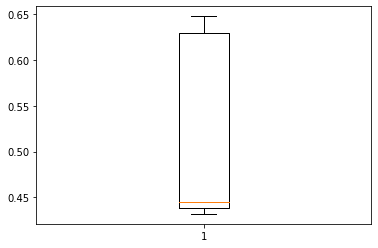

In [278]:
#Box plot de los mejores fitness del entrenamiento (de cada particion)
import matplotlib.pyplot as plt
plt.boxplot(mejores_fitnesses)
plt.show()

In [279]:
#Media de fitness de cada particion en el testeo
part_apts_mean

[0.6130950811705748,
 0.39638280291686,
 0.37232663375403185,
 0.6206893376476567,
 0.40987161836396757]

In [280]:
#Validacion cruzada
print(f"MEDIA: {np.mean(part_apts_mean)}")
print(f"STD: {np.std(part_apts_mean)}")
print(f"MEDIANA: {np.median(part_apts_mean)}")

MEDIA: 0.48247309477061817
STD: 0.1104360346340668
MEDIANA: 0.40987161836396757


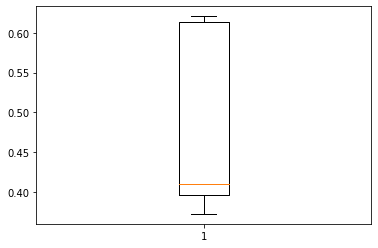

In [281]:
#Box plot de los mejores fitness del testeo (de cada particion)
plt.boxplot(part_apts_mean)
plt.show()

In [282]:
dir_tst = 'resultados/SRGA/test/'
dir_trn = 'resultados/SRGA/train/'

In [283]:
cd SRS/

d:\Documentos\ic_tps\SRS


In [284]:
# Guardar datos de testeo
    np.save(dir_tst + 'v_apts.npy', part_apts)
    np.save(dir_tst + 'mean_apts.npy', part_apts_mean)
    np.save(dir_tst + 'std_apts.npy', part_apts_std)
# Guardar los datos de entrenamiento (alfa, psi, phi, umbral) de cada particion
    np.save(dir_trn + 'v_alfa.npy', part_alfa)
    np.save(dir_trn + 'v_umbral.npy', part_umbral)
    np.save(dir_trn + 'v_phi.npy', part_phi)
    np.save(dir_trn + 'v_psi.npy', part_psi)
    np.save(dir_trn + 'v_best_fitness.npy', mejores_fitnesses)
    np.save(dir_trn + 'v_part_fitness', v_part_fitness)